In [1]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
root_dir = Path(os.getcwd())

In [231]:
word = 'yes'
sample = '0ba018fc_nohash_1.csv'

# Formant Feature Extraction

In [232]:
db = pd.read_csv(root_dir/'feature_database'/word/sample)

In [233]:
sound_db = db[db[' phoneme']=='sounding'].replace(to_replace='--undefined--', value=0)
sound_db[' F1'] = pd.to_numeric(sound_db[' F1'], downcast='float')
sound_db[' F2'] = pd.to_numeric(sound_db[' F2'], downcast='float')
sound_db[' F3'] = pd.to_numeric(sound_db[' F3'], downcast='float')

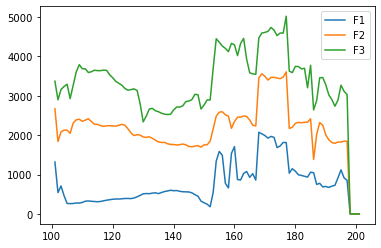

In [234]:
plt.plot(sound_db[' F1'], label = 'F1')
plt.plot(sound_db[' F2'], label = 'F2')
plt.plot(sound_db[' F3'], label = 'F3')
# plt.plot(sound_db[' F4'], label = 'F4')
# plt.plot(sound_db[' F5'], label = 'F5')

plt.legend()
plt.show()

## TODO:
- Feature formant ideas:
    - Difference between formants
    - Formant values themselves (look at if they slope up or down?)
    - Only look at the "voiced" sections

# Spectrogram Feature Extraction

In [235]:
stdb = pd.read_csv(root_dir/'short_text_database'/word/sample)

In [236]:
stdb = stdb.rename(columns={'File type = "ooTextFile"': 'val'})
nx = int(stdb.iloc[3]['val'])
ny = int(stdb.iloc[8]['val'])

new_spectrogram = np.array([[0]*ny]*nx, dtype='float')
linecount = 11
for y in range(ny):
    for x in range(nx):
        new_spectrogram[x][y] = float(stdb.iloc[linecount]['val'])
        linecount += 1
        
new_spectrogram = new_spectrogram.T
log_new_spectrogram = np.log(new_spectrogram)

In [237]:
new_spectrogram.shape

(160, 991)

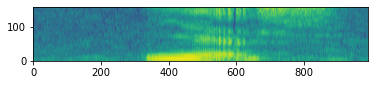

In [238]:
plt.imshow(log_new_spectrogram, origin='lower')

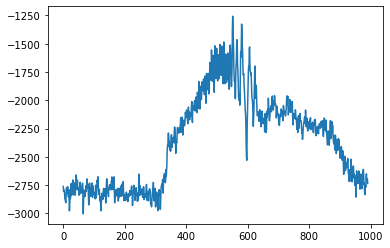

In [239]:
amplitude = np.sum(np.log(new_spectrogram), axis=0)
plt.plot(amplitude)

plt.show()

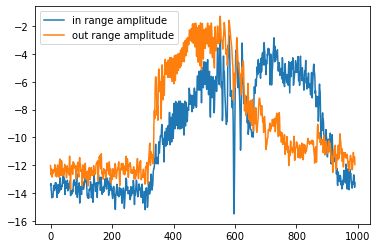

In [240]:
# 160 - 5000 Hz
# 96 - 3000 Hz Lower threshold for [s] sounds
# 16 - 500 Hz There will likely always be something at the fundamental, so we can remove that if needed

f_fund_limit = 16
f_low = 96
f_high = 160

# Here make sure to add (np.sum), THEN do np.log on the result. 
# Logging everything first then adding results in less accurate data.
in_range_spectrogram = new_spectrogram[f_low:f_high]
out_range_spectrogram = new_spectrogram[f_fund_limit:f_low]
in_range_amplitude = np.sum(in_range_spectrogram, axis=0)
out_range_amplitude = np.sum(out_range_spectrogram, axis=0)

plt.plot(np.log(in_range_amplitude), label='in range amplitude')
plt.plot(np.log(out_range_amplitude), label='out range amplitude')

plt.legend()
plt.show()

446.9829100695666
426.40440554185795
417.56343699077524
401.8386247642293
400.97231019229673
386.7456544720673
373.61441899934414
370.9269684903979
360.2834633996051
359.1407087427981
339.8309591612328
339.10088511853667
355.3843957166329
330.9133973280759
348.36740700598125
379.70317756014424
409.3497024511722
374.8992745177559
404.55600065809875
382.22326236438676
383.4960955652149
371.5536359284768


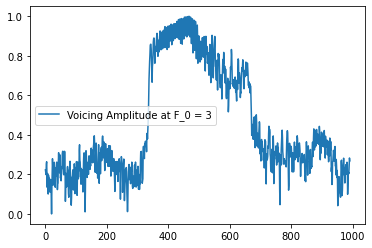

In [241]:
# 160 - 5000 Hz
# 3 - 90 Hz
# 25 - 800 Hz

f_fund_low = 3
f_fund_high = 25
num_harmonics = 5

volume_offset_spectrogram = log_new_spectrogram[0:num_harmonics*f_fund_high]
volume_offset_amplitude = (1/(num_harmonics*f_fund_high+1)) * np.sum(volume_offset_spectrogram, axis=0)

voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
f_fund = 0
for f in range(f_fund_low, f_fund_high):
    test_voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
    for i in range(1, num_harmonics+1):
        test_voicing_amplitude += (log_new_spectrogram[i*f]) # This is what the paper did, but maybe isn't good (log_new_spectrogram[i*f] - volume_offset_amplitude)
    # Normalize
    max_val = np.quantile(test_voicing_amplitude, 1)
    min_val = np.quantile(test_voicing_amplitude, 0)
    test_voicing_amplitude = (test_voicing_amplitude - min_val) / (max_val - min_val)
    # Find f that gives the greatest magnitude
    curr_sum = np.sum(test_voicing_amplitude)
    print(curr_sum)
    if (curr_sum > np.sum(voicing_amplitude)):
        voicing_amplitude = test_voicing_amplitude
        f_fund = f

plt.plot(voicing_amplitude, label='Voicing Amplitude at F_0 = {f}'.format(f=f_fund))

plt.legend()
plt.show()

## TODO
- Looks like to detect [s], we specifically want to check the difference between in range and out range amplitude, where in range should be bigger. Might need to increase frequencies to 6KHz to see a more clear [s] amplitude difference.